In [1]:
import os
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import omicverse as ov
import scvi
from scvi.model.utils import mde

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.3, Tutorials: https://omicverse.readthedocs.io/


[rank: 0] Global seed set to 0


In [2]:
import matplotlib

# Set matplotlib to save text as text (not paths)
matplotlib.rcParams['pdf.fonttype'] = 42  # TrueType fonts
matplotlib.rcParams['ps.fonttype'] = 42   # For postscript output

# Set your figure parameters
sc.settings.set_figure_params(
    dpi=100,
    frameon=False,
    figsize=(3, 3),
    vector_friendly=True,  # This is important!
    fontsize=8
)

In [3]:
# Load dataset
os.chdir("/storage2/liuxiaodongLab/fanxueying/liu-lab_projects/XueyingFan/Hypoblast/code/20260210_hypo_final_99")
adata = sc.read('/storage2/liuxiaodongLab/jiangjing/Projects/XueyingFan/PD_XueyingFan/20260209_hypoblast_99sample_anno/output/adata_qc_with_groups_scpoli_reanno.h5ad')
adata

AnnData object with n_obs × n_vars = 1170931 × 37165
    obs: 'condition', 'cell_name_in_hg38_mm10', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden', 'group', 'day', 'group_day', 'orig.ident', 'is_original_query', 'original_query_id', 'lineage_pred', 'lineage_uncert', 'leiden_res_0.4', 'celltype'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_res_0.4_colors', 'lineage_pred_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_scpoli_lineage', 'scpoli'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'connectivities', 'distances'

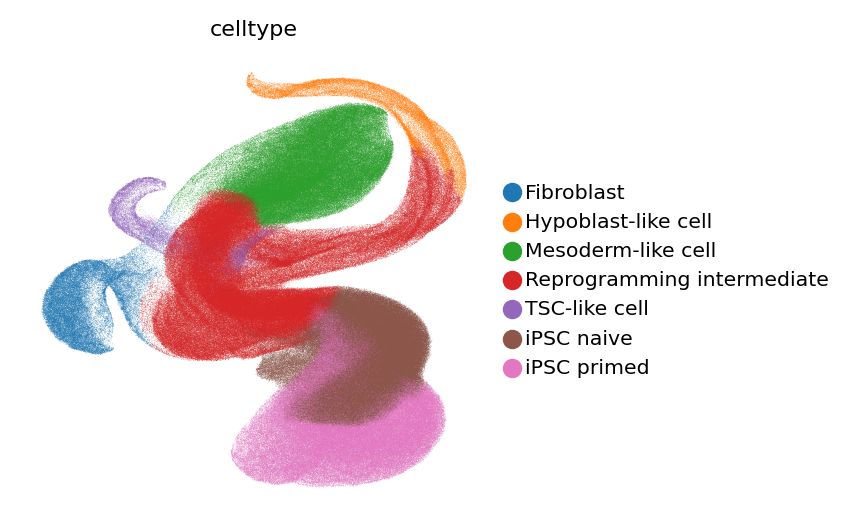

In [4]:
sc.pl.umap(
    adata,
    color="celltype",
    save="hypo99_celltype_umap.pdf"  # Saves as 'figures/umap_celltype_umap.pdf'
)

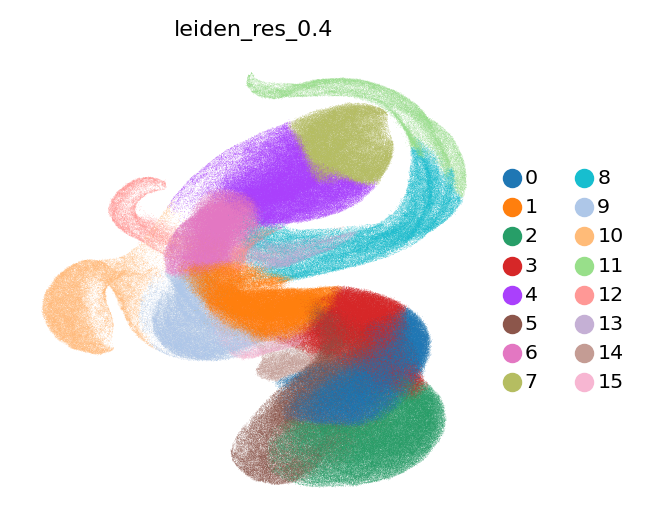

In [5]:
sc.pl.umap(
    adata,
    color="leiden_res_0.4",
    save="hypo100_leiden_scpoli_umap.pdf" )

In [6]:
sc.tl.leiden(adata, resolution=1, key_added="leiden_res_1")

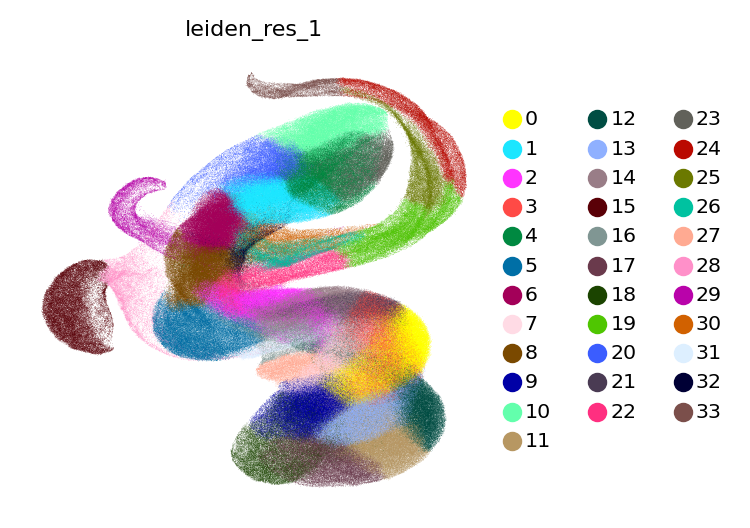

In [7]:
sc.pl.umap(
    adata,
    color="leiden_res_1",
    save="hypo100_leiden_scpoli_umap.pdf" )

In [13]:
sc.tl.leiden(adata, resolution=0.6, key_added="leiden_res_0.6")

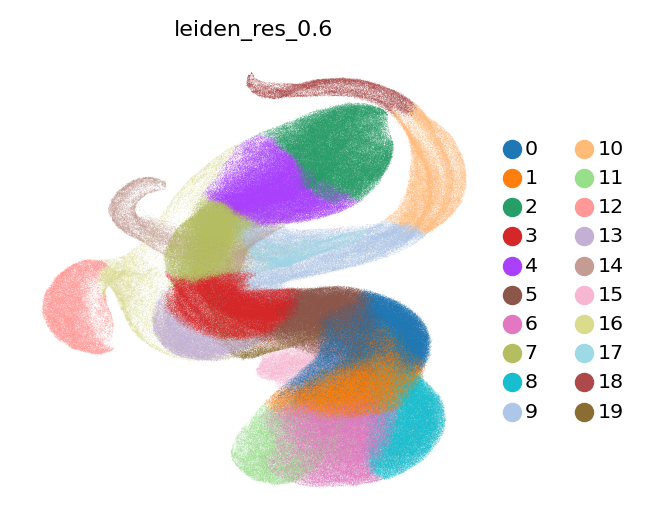

In [14]:
sc.pl.umap(
    adata,
    color="leiden_res_0.6",
    save="hypo100_leiden_scpoli_umap.pdf" )

In [20]:
#rename
# add a new column
adata.obs['celltype'] = adata.obs['leiden_res_0.6'].cat.add_categories(['Fibroblast', 'Reprogramming intermediate',
                                                                                       'iPSC primed', 'iPSC_naive', 'Hypoblast-like cell',
                                                                                       'TSC-like cell','Mesoderm-like cell'
                                                                                       
])

adata.obs['celltype'][np.in1d(adata.obs['celltype'], ['12', '16' ])] = 'Fibroblast'
adata.obs['celltype'][np.in1d(adata.obs['celltype'], ['10', '18' ])] = 'Hypoblast-like cell'
adata.obs['celltype'][np.in1d(adata.obs['celltype'], ['0', '1', '5', '15', '19' ])] = 'iPSC_naive'
adata.obs['celltype'][np.in1d(adata.obs['celltype'], ['6', '8','11',])] = 'iPSC primed'
adata.obs['celltype'][np.in1d(adata.obs['celltype'], [ '2', '4', ])] = 'Mesoderm-like cell'
adata.obs['celltype'][np.in1d(adata.obs['celltype'], ['3','7','9', '13','17' ])] = 'Reprogramming intermediate'
adata.obs['celltype'][np.in1d(adata.obs['celltype'], ['14' ])] = 'TSC-like cell'

adata.obs['celltype'] = adata.obs['celltype'].cat.remove_unused_categories()

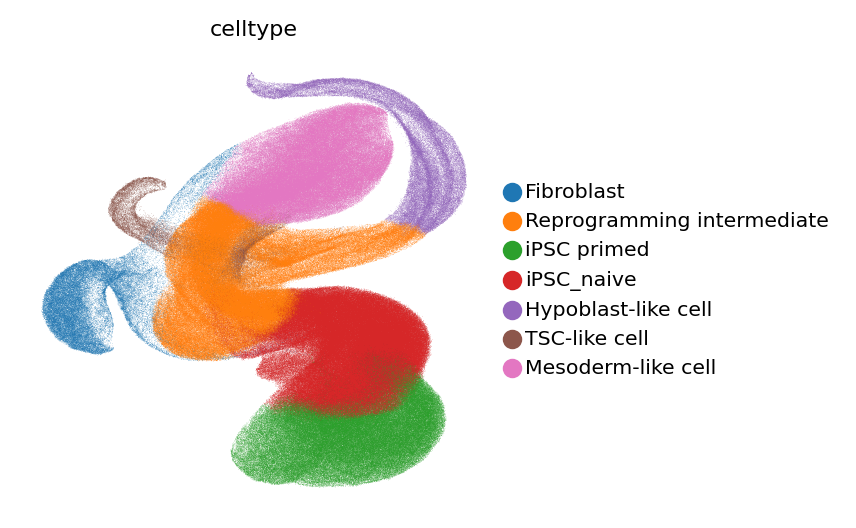

In [21]:
sc.pl.umap(
    adata,
    color="celltype",
    save="hypo99_celltype_umap.pdf"  # Saves as 'figures/umap_celltype_umap.pdf'
)

In [22]:
marker_dict_select = {
    'Fibroblast': ['COL1A1', 'FN1', 'MMP2', 'VIM', 'DCN', 'LUM' ], #'ZEB1','TWIST1','TWIST2'
    'iPSC naive': ['DPPA5', 'DPPA3',  'DNMT3L','NANOG', 'KLF5',  ], # 'DPPA2',
    'iPSC primed': [ 'LIN28A', 'EPCAM', 'POU5F1', 'CD24', 'SOX11', 'SOX2',],
    'TSC': ['GATA3', 'TFAP2C', 'TFAP2A','GATA2', 'KRT7'], #'MSX2', 'CDX2'
    'Hypoblast': ['SOX17', 'GATA4', 'GATA6', 'PDGFRA', 'FOXA2'],
    'mesoderm/mesenchymal':['CDX2','TWIST1','ACTA2','RGS5'], #,'BMP4',
}

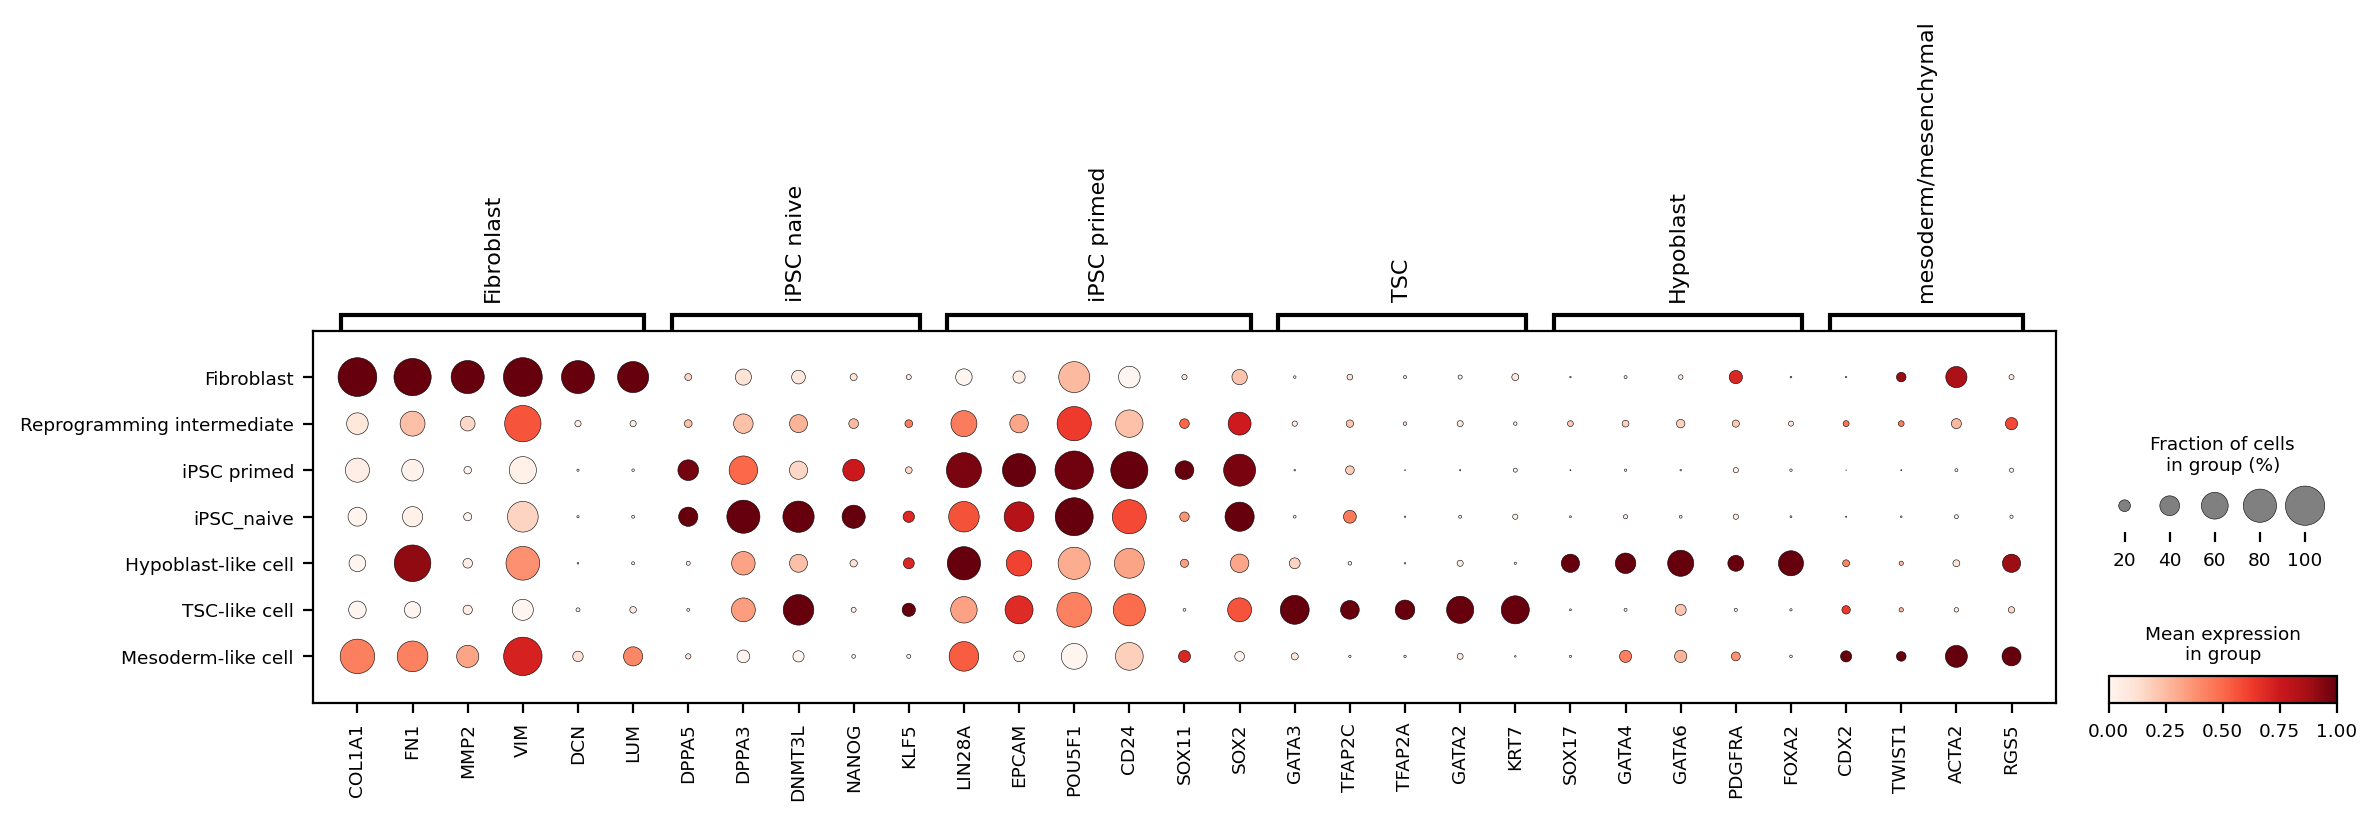

In [23]:
# Flatten your marker_dict_select into a list
all_markers = [gene for group in marker_dict_select.values() for gene in group]

# Find which ones exist in your dataset
existing_markers = [g for g in all_markers if g in adata.var_names]

# Optional: Report missing genes
missing = set(all_markers) - set(existing_markers)
if missing:
    print(f"⚠️ Missing {len(missing)} genes: {sorted(missing)}")

# Rebuild marker_dict_select dict with only existing genes
filtered_marker_genes = {}
for group, genes in marker_dict_select.items():
    filtered = [g for g in genes if g in adata.var_names]
    if filtered:  # Only keep groups with at least one gene
        filtered_marker_genes[group] = filtered

# Now plot
sc.pl.dotplot(
    adata,
    filtered_marker_genes,
    groupby="celltype",
    standard_scale="var",
    save="hypo100_marker_dotplot.pdf"  # Add this line
)

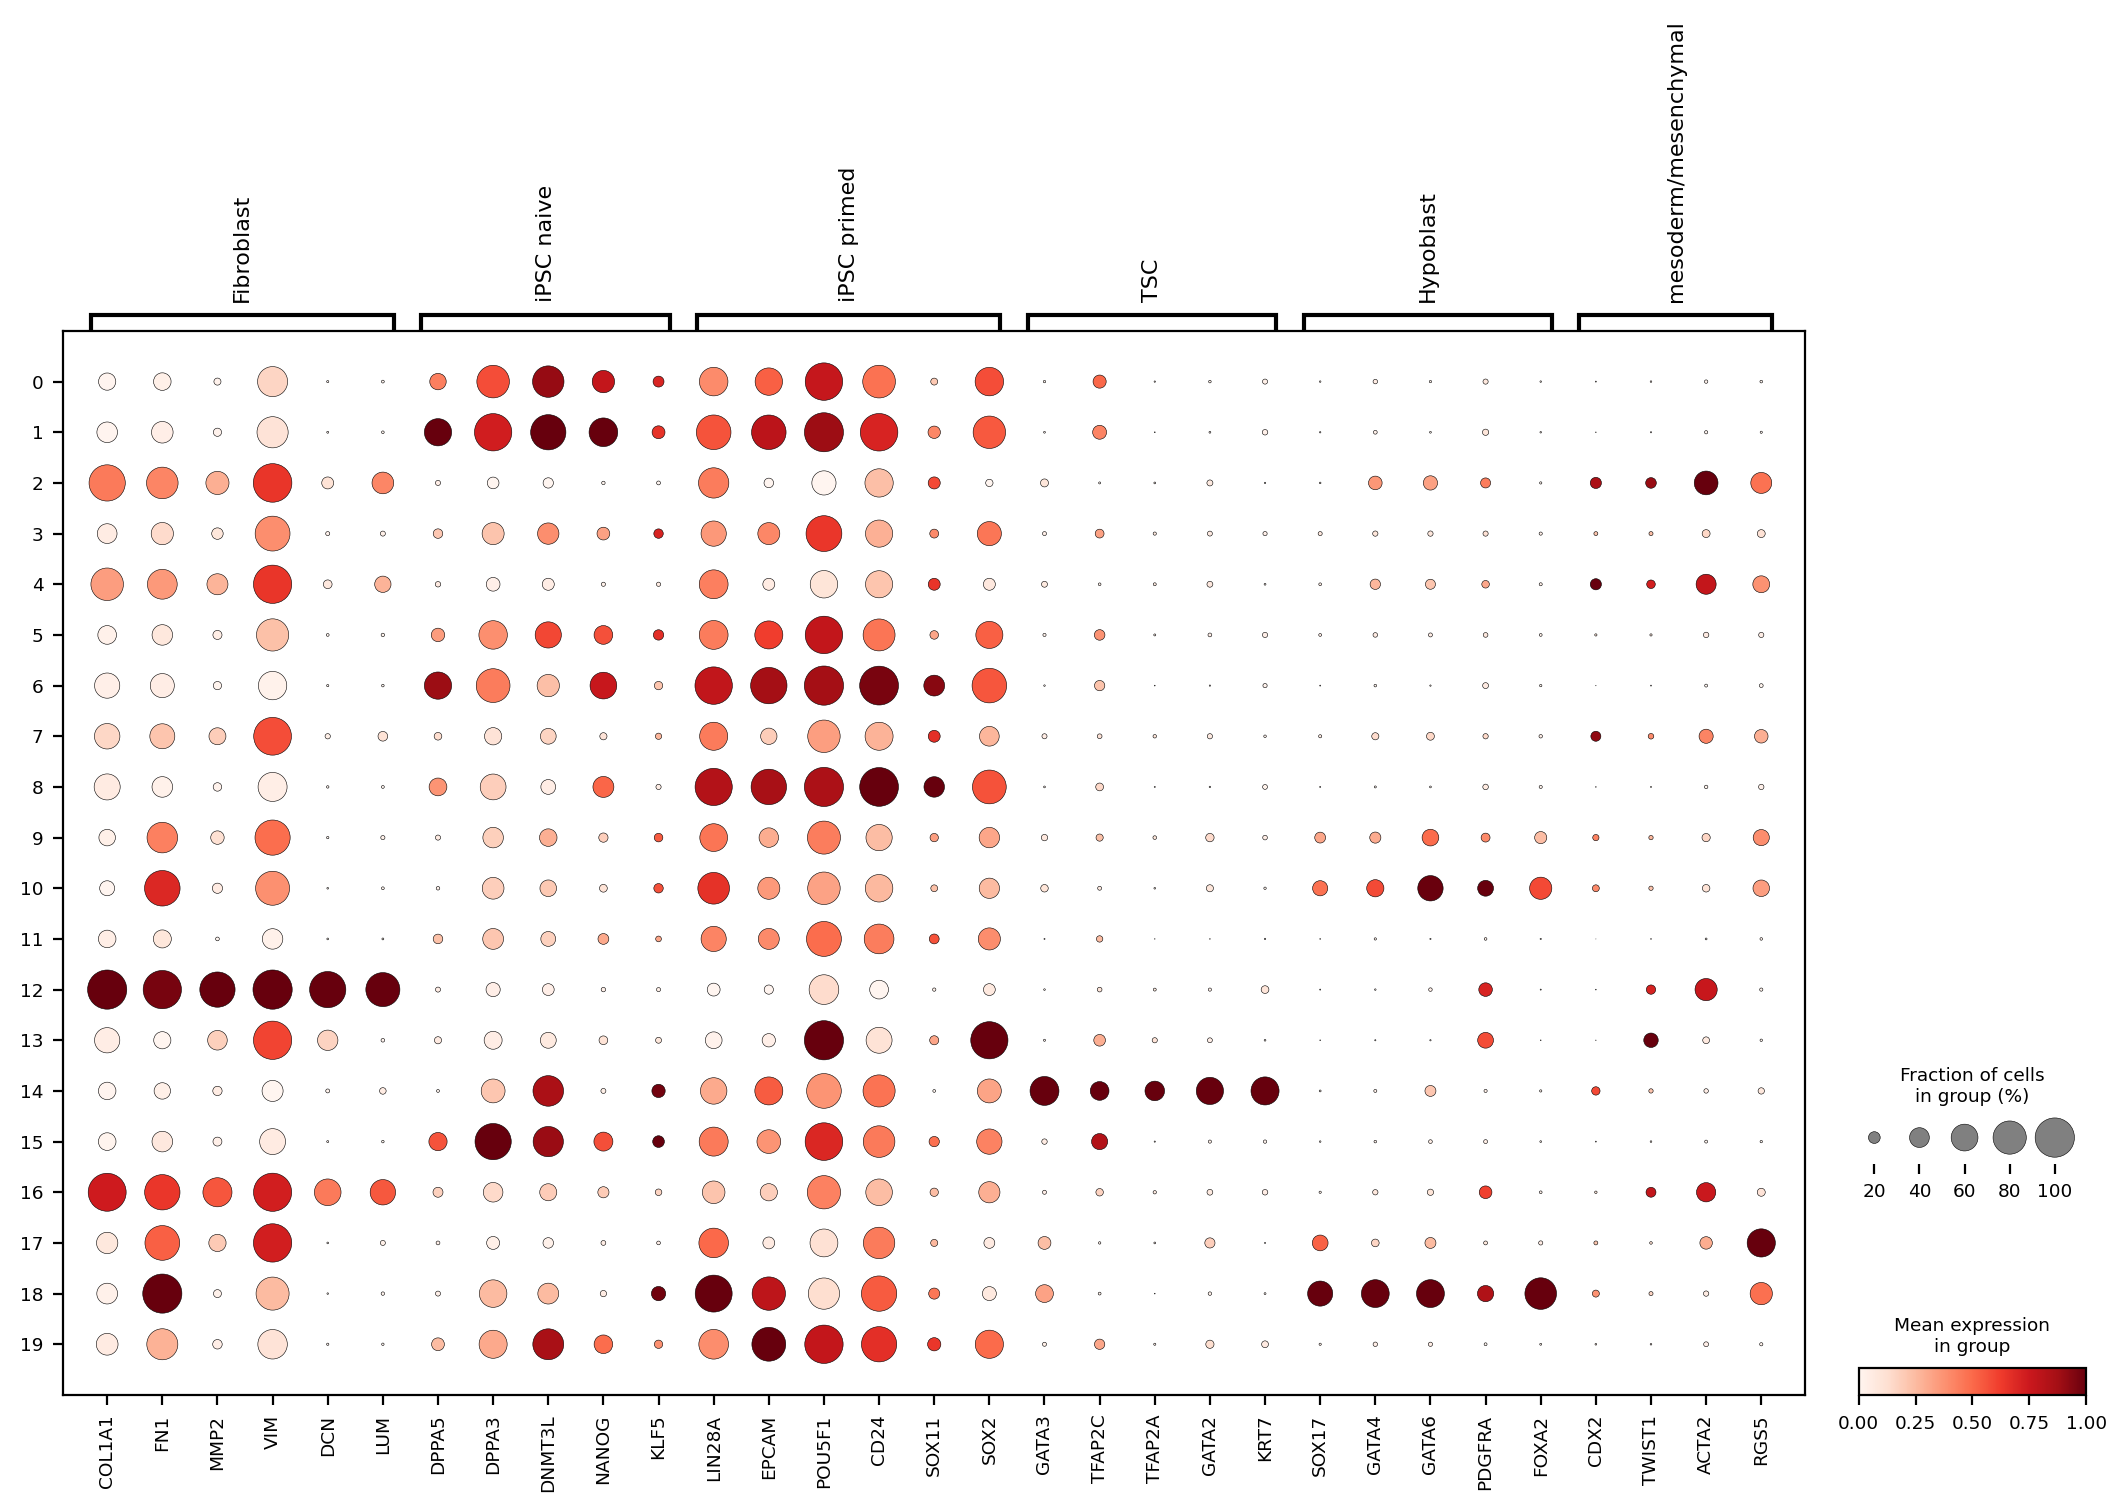

In [24]:
# Flatten your marker_dict_select into a list
all_markers = [gene for group in marker_dict_select.values() for gene in group]

# Find which ones exist in your dataset
existing_markers = [g for g in all_markers if g in adata.var_names]

# Optional: Report missing genes
missing = set(all_markers) - set(existing_markers)
if missing:
    print(f"⚠️ Missing {len(missing)} genes: {sorted(missing)}")

# Rebuild marker_dict_select dict with only existing genes
filtered_marker_genes = {}
for group, genes in marker_dict_select.items():
    filtered = [g for g in genes if g in adata.var_names]
    if filtered:  # Only keep groups with at least one gene
        filtered_marker_genes[group] = filtered

# Now plot
sc.pl.dotplot(
    adata,
    filtered_marker_genes,
    groupby="leiden_res_0.6",
    standard_scale="var"
)

In [25]:
set(adata.obs['condition'])

{'H10',
 'H100',
 'H109',
 'H11',
 'H110',
 'H112',
 'H113',
 'H114',
 'H115',
 'H118',
 'H119',
 'H126',
 'H127',
 'H13',
 'H132',
 'H133',
 'H136',
 'H137',
 'H138',
 'H14',
 'H141',
 'H142',
 'H149',
 'H15',
 'H159',
 'H16',
 'H160',
 'H161',
 'H162',
 'H164',
 'H165',
 'H166',
 'H167',
 'H168',
 'H169',
 'H17',
 'H170',
 'H171',
 'H172',
 'H18',
 'H19',
 'H21',
 'H22',
 'H23',
 'H24',
 'H25',
 'H26',
 'H27',
 'H29',
 'H30',
 'H31',
 'H32',
 'H33',
 'H35',
 'H36',
 'H37',
 'H38',
 'H39',
 'H4',
 'H41',
 'H42',
 'H43',
 'H45',
 'H46',
 'H47',
 'H49',
 'H5',
 'H50',
 'H51',
 'H52',
 'H55',
 'H56',
 'H57',
 'H6',
 'H62',
 'H63',
 'H64',
 'H68',
 'H7',
 'H70',
 'H71',
 'H74',
 'H75',
 'H8',
 'H81',
 'H82',
 'H83',
 'H85',
 'H86',
 'H87',
 'H9',
 'H91',
 'H92',
 'H93',
 'H95',
 'H96',
 'H97',
 'H99',
 'control'}

In [26]:
# Read the Excel file
meta = pd.read_excel("hypoblast_data_info_removeH163.xlsx")
# Display first few rows to verify
print(meta.head())

  Sample ID  Day    Group       SM_1 SM_2 SM_3 SM_4 SM_5 SM_6  Unnamed: 9  \
0        H1    7     Ctrl        NaN  NaN  NaN  NaN  NaN  NaN         NaN   
1        H4   20     Ctrl        NaN  NaN  NaN  NaN  NaN  NaN         NaN   
2        H5   20  Pert_1X  Activin-A  NaN  NaN  NaN  NaN  NaN         NaN   
3        H6   20  Pert_1X     A83-01  NaN  NaN  NaN  NaN  NaN         NaN   
4        H7   20  Pert_1X       BMP4  NaN  NaN  NaN  NaN  NaN         NaN   

  group  Batch  
0   ctl  seq_8  
1   ctl  seq_7  
2   Act  seq_1  
3   A83  seq_1  
4  BMP4  seq_1  


In [27]:
# Set 'Sample ID' as index for mapping
meta_indexed = meta.set_index('Sample ID')

# Map the Group column
adata.obs['sample_group'] = adata.obs['condition'].map(meta_indexed['Group'])

# Fix the "control" vs "Ctrl" issue
# Check if "control" exists and what it should map to
if 'control' in adata.obs['condition'].unique():
    print("\nFixing 'control' mapping...")
    
    # Option 1: Directly map "control" to "Ctrl"
    control_mask = adata.obs['condition'] == 'control'
    adata.obs.loc[control_mask, 'sample_group'] = 'Ctrl'
    
    print(f"Fixed {control_mask.sum()} 'control' cells to 'Ctrl'")
    
    # Option 2: Or check what "control" cells should be based on other columns
    # if you have additional metadata

# Check results again
print(f"\nFinal mapping results:")
print(f"Total cells: {len(adata):,}")
print(f"Mapped cells: {(~adata.obs['sample_group'].isna()).sum():,}")
print(f"Missing values: {adata.obs['sample_group'].isna().sum():,}")

# Show value counts
print("\nDistribution of sample_group:")
print(adata.obs['sample_group'].value_counts(dropna=False).head(10))

# If there are still missing values, let's see what they are
missing_mask = adata.obs['sample_group'].isna()
if missing_mask.any():
    print(f"\nCells with missing sample_group ({missing_mask.sum():,}):")
    missing_conditions = adata.obs.loc[missing_mask, 'condition'].unique()
    print(f"Unmapped conditions: {missing_conditions}")
    
    # Option: Fill with condition value or 'Unknown'
    adata.obs.loc[missing_mask, 'sample_group'] = adata.obs.loc[missing_mask, 'condition']
    print(f"Filled missing with condition values")


Fixing 'control' mapping...
Fixed 5347 'control' cells to 'Ctrl'

Final mapping results:
Total cells: 1,170,931
Mapped cells: 1,170,931
Missing values: 0

Distribution of sample_group:
Pert_3X    508424
Pert_2X    369346
Pert_1X     99942
Pert_6X     85334
Pert_4X     53975
Pert_5X     34365
Ctrl        19545
Name: sample_group, dtype: int64


In [28]:
# Define testing conditions
testing_conditions = {
    'H149', 'H159', 'H160', 'H161', 'H162', 'H165', 'H166', 
    'H167', 'H168', 'H169', 'H170', 'H171', 'H172'
}

# Create the 'splitset' column
adata.obs['splitset'] = 'training'  # Default value

# Assign 'testing' for specified conditions
adata.obs.loc[adata.obs['condition'].isin(testing_conditions), 'splitset'] = 'testing'

# Make it categorical with specific order
adata.obs['splitset'] = pd.Categorical(
    adata.obs['splitset'],
    categories=['training', 'testing'],  # training first
    ordered=True
)

# Verify the split
print("Split distribution:")
print(adata.obs['splitset'].value_counts())
print()

print("Conditions mapped to testing set:")
testing_conditions_found = adata.obs[adata.obs['splitset'] == 'testing']['condition'].unique()
print(sorted(testing_conditions_found))
print()

print("Conditions mapped to training set (sample):")
training_conditions = adata.obs[adata.obs['splitset'] == 'training']['condition'].unique()
print(f"Total training conditions: {len(training_conditions)}")
print("First 10 training conditions:", sorted(training_conditions)[:10] if len(training_conditions) > 10 else sorted(training_conditions))

Split distribution:
training    1007526
testing      163405
Name: splitset, dtype: int64

Conditions mapped to testing set:
['H149', 'H159', 'H160', 'H161', 'H162', 'H165', 'H166', 'H167', 'H168', 'H169', 'H170', 'H171', 'H172']

Conditions mapped to training set (sample):
Total training conditions: 86
First 10 training conditions: ['H10', 'H100', 'H109', 'H11', 'H110', 'H112', 'H113', 'H114', 'H115', 'H118']


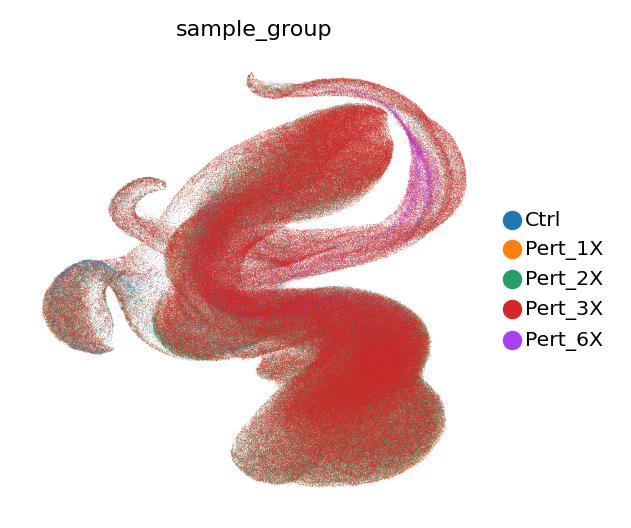

In [29]:
training_sub= adata[adata.obs['splitset'].isin([ 'training'])]
sc.pl.umap(training_sub, color=['sample_group'])

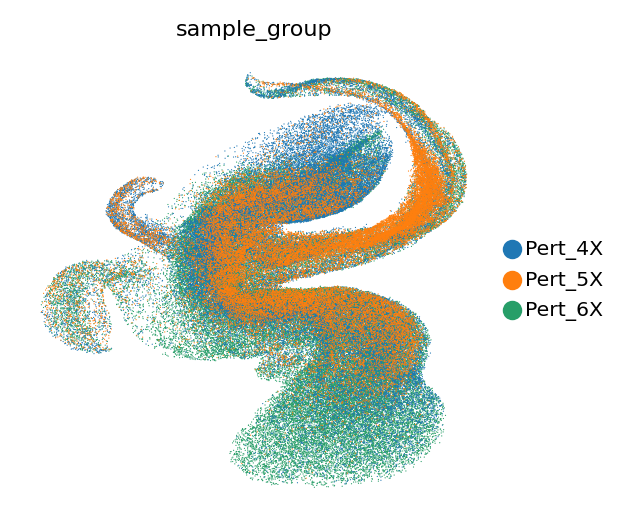

In [30]:
testing_sub= adata[adata.obs['splitset'].isin([ 'testing'])]
sc.pl.umap(testing_sub, color=['sample_group'])

All groups in dataset: ['Ctrl', 'Pert_1X', 'Pert_2X', 'Pert_3X', 'Pert_4X', 'Pert_5X', 'Pert_6X']
Color mapping for Pert_6X: #9edae5


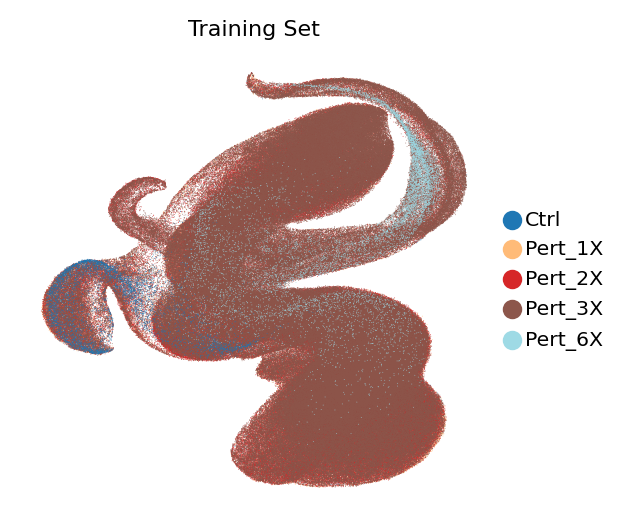

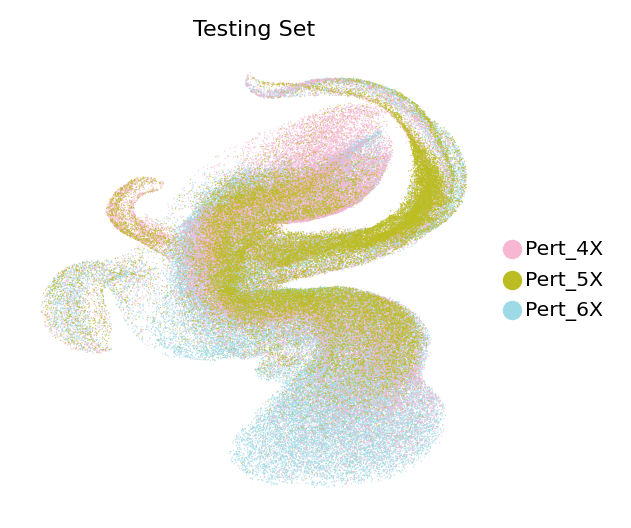

In [67]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors

# Get ALL unique groups from the FULL dataset
all_groups = sorted(adata.obs['sample_group'].unique())
print(f"All groups in dataset: {all_groups}")

# Using Tab20c colormap (has 20*4 = 80 distinct colors)
colors = cm.tab20(np.linspace(0, 1, len(all_groups)))
color_dict = {group: matplotlib.colors.to_hex(colors[i]) for i, group in enumerate(all_groups)}

print(f"Color mapping for Pert_6X: {color_dict.get('Pert_6X', 'Not found')}")

# Plot training with consistent colors
sc.pl.umap(
    training_sub,
    color=['sample_group'],
    palette=color_dict,  # Use the same color dictionary
    size=0.4,
    alpha=0.8,
    frameon=False,
    title='Training Set',
    save='_training_consistent.pdf'
)

# Plot testing with the SAME color dictionary
sc.pl.umap(
    testing_sub,
    color=['sample_group'],
    palette=color_dict,  # Same color dictionary
    size=0.8,
    alpha=0.8,
    frameon=False,
    title='Testing Set',
    save='_testing_consistent.pdf'
)

Cross-tab shape: (99, 7)
Sample of the table:
celltype                Fibroblast  Hypoblast-like cell  Mesoderm-like cell  \
group                                                                         
A83                       7.923762             0.106424            0.106424   
A83_BMP4                  5.603329             3.208507            3.735552   
A83_BMP4_CHIR             8.231614             4.171011           52.352328   
A83_BMP4_CHIR_FGF4_LIF    1.011703            38.082295           15.115138   
A83_BMP4_FGF4             4.003307            62.753897            2.822390   

celltype                Reprogramming intermediate  TSC-like cell  \
group                                                               
A83                                      11.000387       0.203173   
A83_BMP4                                 13.129912      49.153953   
A83_BMP4_CHIR                            16.352818      13.341103   
A83_BMP4_CHIR_FGF4_LIF                   44.967912     

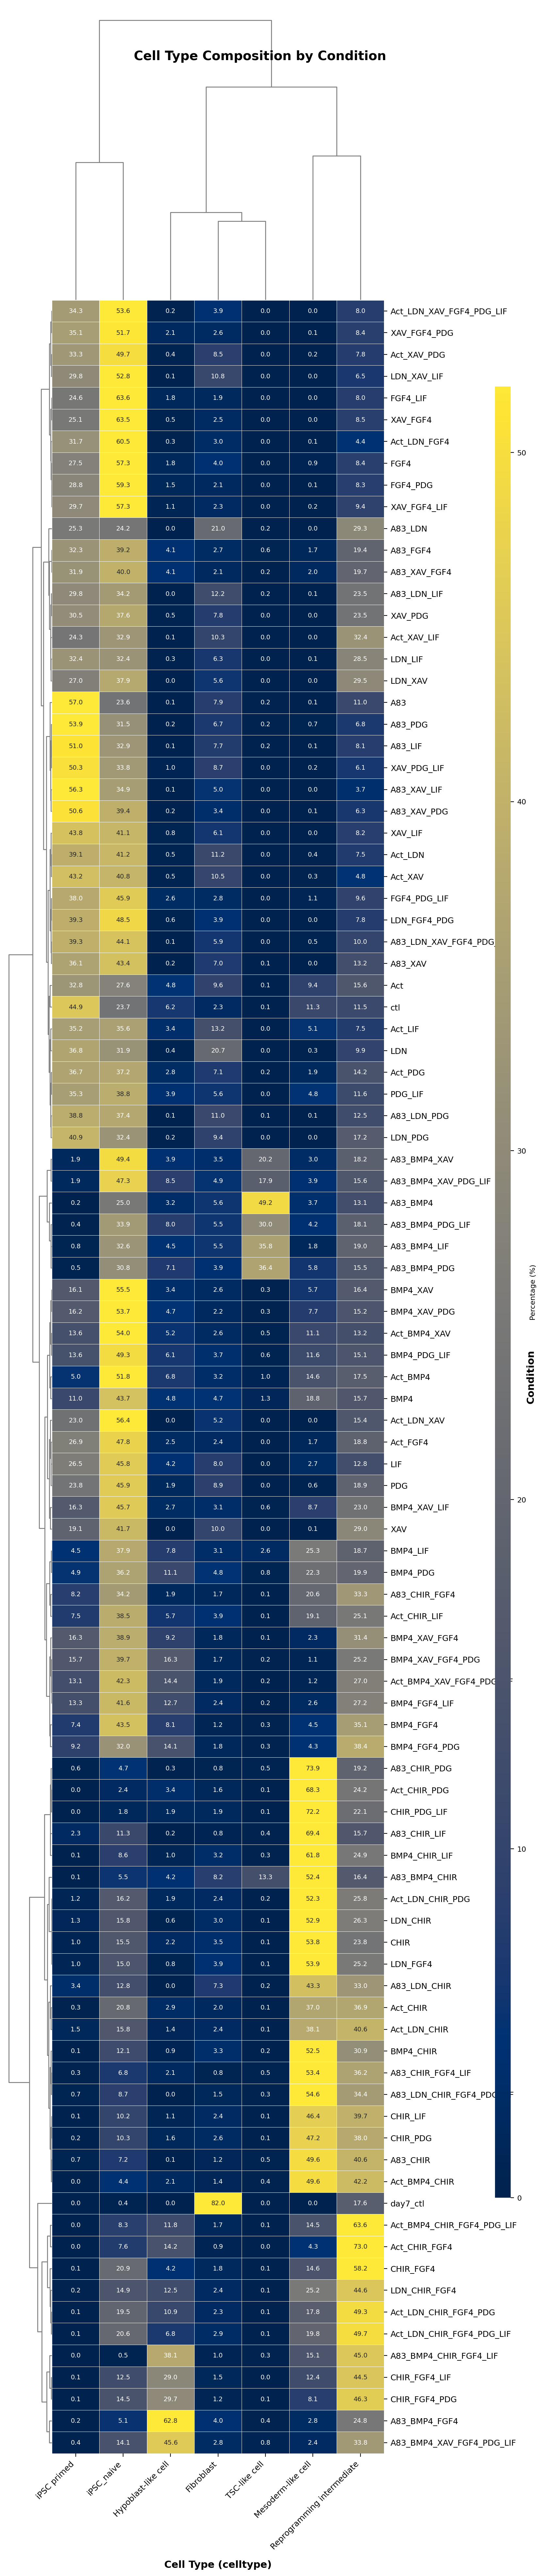

In [32]:
# Step 1: 提取所需列
df = adata.obs[['group', 'celltype']].copy()

# 可选：确保是字符串类型（避免 categorical 问题）
df['group'] = df['group'].astype(str)
df['celltype'] = df['celltype'].astype(str)

# Step 2: 计算交叉表 —— 每个 group 内部的 celltype 百分比
cross_tab = pd.crosstab(
    df['group'], 
    df['celltype'], 
    normalize='index'  # 按 group 行归一化
) * 100

print(f"Cross-tab shape: {cross_tab.shape}")
print("Sample of the table:")
print(cross_tab.head())

# Step 3: 确定颜色范围（排除0后的95%分位数）
all_vals = cross_tab.values.flatten()
vmin = 0
vmax = np.percentile(all_vals[all_vals > 0], 95) if np.any(all_vals > 0) else 100

# Step 4: 绘制 clustermap
g = sns.clustermap(
    cross_tab,
    cmap='cividis',
    method='ward',
    metric='euclidean',
    figsize=(max(8, cross_tab.shape[1] * 0.6), max(6, cross_tab.shape[0] * 0.4)),
    linewidths=0.3,
    linecolor='white',
    cbar_kws={'label': 'Percentage (%)', 'shrink': 0.5},
    annot=True,
    fmt='.1f',
    annot_kws={'size': 7},
    vmin=vmin,
    vmax=vmax,
    dendrogram_ratio=0.12,
    colors_ratio=0.03,
    cbar_pos=(0.95, 0.15, 0.03, 0.7),
    tree_kws={'linewidths': 1.0, 'colors': 'gray'}
)

# 标题和标签
plt.suptitle('Cell Type Composition by Condition', fontsize=14, fontweight='bold', y=0.98)
g.ax_heatmap.set_xlabel('Cell Type (celltype)', fontsize=11, fontweight='bold', labelpad=10)
g.ax_heatmap.set_ylabel('Condition', fontsize=11, fontweight='bold', labelpad=10)

# 调整标签旋转
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=9)

# 灰色树状图
for ax in [g.ax_col_dendrogram, g.ax_row_dendrogram]:
    if ax:
        for line in ax.collections:
            line.set_color('gray')
            line.set_linewidth(1.0)

# 保存
# g.savefig('clustermap_condition_vs_reanno_manual.png', dpi=300, bbox_inches='tight', facecolor='white')
g.savefig('clustermap_condition_vs_reanno_manual.pdf', bbox_inches='tight')
print("Saved clustermap_condition_vs_reanno_manual.png/pdf")

# 保存聚类后数据
col_order = g.dendrogram_col.reordered_ind
row_order = getattr(g.dendrogram_row, 'reordered_ind', None)
clustered_data = cross_tab.iloc[:, col_order]
if row_order is not None:
    clustered_data = clustered_data.iloc[row_order, :]
clustered_data.to_csv('clustered_data_condition_reanno_manual.csv')
print("Saved clustered data to clustered_data_condition_reanno_manual.csv")

plt.show()

Using clustered group order from file (99 conditions)
Binary matrix shape: (99, 9)
Sample:
                          Activin-A  A83-01  BMP4  LDN193  CHIR99021  XAV939  \
Act_LDN_XAV_FGF4_PDG_LIF          1       0     0       1          0       1   
XAV_FGF4_PDG                      0       0     0       0          0       1   
Act_XAV_PDG                       1       0     0       0          0       1   
LDN_XAV_LIF                       0       0     0       1          0       1   
FGF4_LIF                          0       0     0       0          0       0   

                          FGF4  PDGFAA  LIF  
Act_LDN_XAV_FGF4_PDG_LIF     1       1    1  
XAV_FGF4_PDG                 1       1    0  
Act_XAV_PDG                  0       1    0  
LDN_XAV_LIF                  0       0    1  
FGF4_LIF                     1       0    1  
Saved small_molecule_composition_heatmap.png/pdf


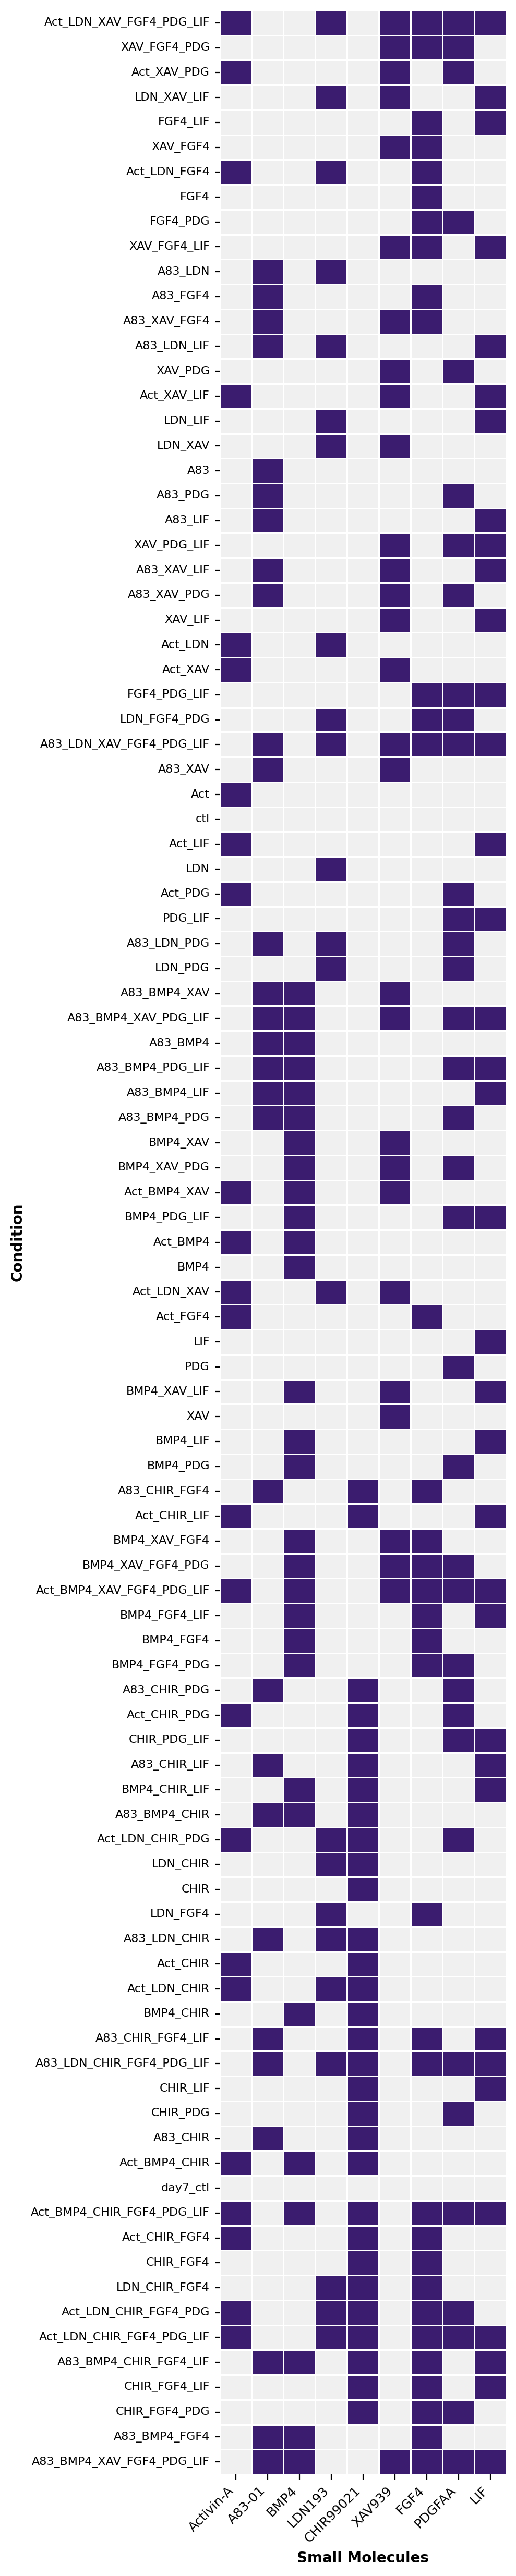

In [33]:
# 1. Define the full list of small molecules (in desired column order)
molecules = ["Activin-A", "A83-01", "BMP4","LDN193", "CHIR99021", "XAV939", "FGF4", "PDGFAA", "LIF"]

# Map short names in group string to full molecule names
# (based on your example: "A83" → "A83-01", "PDG" → "PDGFAA", etc.)
short_to_full = {
    "A83": "A83-01",
    "BMP4": "BMP4",
    "XAV": "XAV939",
    "FGF4": "FGF4",
    "PDG": "PDGFAA",  # assuming PDG = PDGFAA
    "LIF": "LIF",
    "LDN": "LDN193",
    "CHIR": "CHIR99021",
    "Act":  "Activin-A",
    
}

# Reverse map for fast lookup: full name → short token
full_to_short = {v: k for k, v in short_to_full.items()}

# 2. Get the list of conditions in the SAME ORDER as your percentage heatmap
# ⚠️ Important: Use the row order from your clustered percentage heatmap!
# If you saved `clustered_data_condition_reanno_manual.csv`, read it:
try:
    clustered_df = pd.read_csv("clustered_data_condition_reanno_manual.csv", index_col=0)
    condition_order = clustered_df.index.tolist()
    print(f"Using clustered group order from file ({len(condition_order)} conditions)")
except FileNotFoundError:
    # Fallback: use original order from adata_full.obs['group']
    condition_order = adata_full.obs['group'].astype('category').cat.categories.tolist()
    print("Using original group order (no clustering file found)")

# Remove duplicates while preserving order (in case)
condition_order = list(dict.fromkeys(condition_order))

# 3. Build binary matrix
binary_matrix = []

for cond in condition_order:
    # Split group string by '_' to get components
    tokens = set(cond.split('_'))
    row = []
    for mol in molecules:
        short_token = full_to_short[mol]
        present = 1 if short_token in tokens else 0
        row.append(present)
    binary_matrix.append(row)

# Create DataFrame
binary_df = pd.DataFrame(
    binary_matrix,
    index=condition_order,
    columns=molecules
)

print("Binary matrix shape:", binary_df.shape)
print("Sample:")
print(binary_df.head())

# 4. Plot binary heatmap (aligned with percentage heatmap rows)
plt.figure(figsize=(5, max(4, len(condition_order) * 0.25)))  # narrow width, same height logic

g = sns.heatmap(
    binary_df,
    #cmap=['#EAEAEA', '#2171B5'],  # 0 = white, 1 = colored
    cmap=['#F0F0F0', '#3B1C6F'],
    cbar=False,
    linewidths=0.5,
    linecolor='white',
    xticklabels=True,
    yticklabels=True
)

# Styling
g.set_xlabel("Small Molecules", fontsize=10, fontweight='bold')
g.set_ylabel("Condition", fontsize=10, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=8)

# Save
plt.tight_layout()
# plt.savefig("small_molecule_composition_heatmap.png", dpi=300, bbox_inches='tight')
plt.savefig("small_molecule_composition_heatmap.pdf", bbox_inches='tight')
print("Saved small_molecule_composition_heatmap.png/pdf")

plt.show()

Proportion matrix shape: (99, 7)
Saved cell_proportion_per_condition.png/pdf


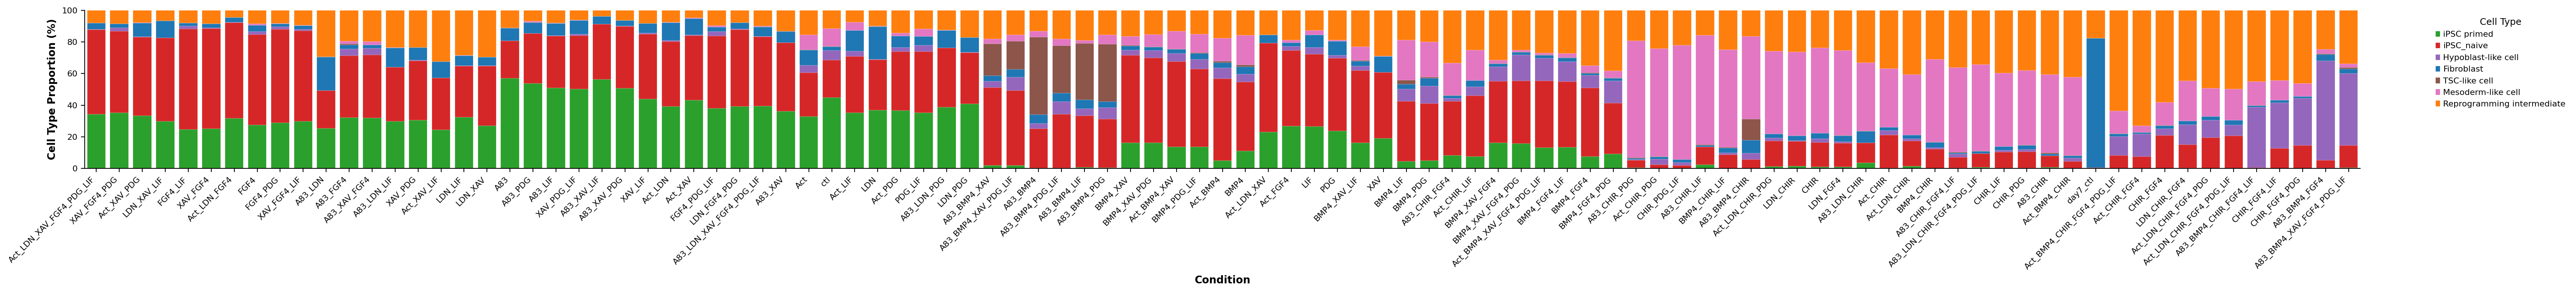

In [34]:
# 1. Load the clustered group order (from your heatmap)
clustered_df = pd.read_csv("clustered_data_condition_reanno_manual.csv", index_col=0)
condition_order = clustered_df.index.tolist()

# 2. Extract cell counts per (group, celltype) from ORIGINAL adata
#    (because clustered_data only has percentages, not raw counts)
df_obs = adata.obs[['group', 'celltype']].copy()

# Ensure group is categorical with your desired order
df_obs['group'] = pd.Categorical(df_obs['group'], categories=condition_order, ordered=True)
df_obs = df_obs[df_obs['group'].notna()]  # remove any not in condition_order

# 3. Compute proportion per group
prop_df = df_obs.groupby('group')['celltype'].value_counts(normalize=True).unstack(fill_value=0)

# Reorder columns to match heatmap column order (if available)
# If you saved the clustered column order, use it; otherwise use current order
try:
    # The columns in clustered_df are the cell types in heatmap column order
    celltype_order = clustered_df.columns.tolist()
    prop_df = prop_df[celltype_order]  # reorder columns
except KeyError as e:
    print(f"Warning: some cell types missing in proportion data: {e}")
    # Keep existing order

print("Proportion matrix shape:", prop_df.shape)

# 4. Get color mapping for 'celltype'
# Option A: Use colors from adata.uns (if you set them via sc.pl)
color_key = 'celltype_colors'  # common key if set by scanpy
if 'celltype' in adata.uns:
    # Sometimes stored as adata.uns['reanno_manual_colors']
    color_key = 'celltype_colors'

if color_key in adata.uns:
    # Map category to color
    categories = adata.obs['celltype'].cat.categories
    color_map = dict(zip(categories, adata.uns[color_key]))
elif hasattr(adata.obs['celltype'], 'cat'):
    # Fallback: generate consistent colormap
    import seaborn as sns
    categories = adata.obs['celltype'].cat.categories
    palette = sns.color_palette("tab20", n_colors=len(categories))
    color_map = dict(zip(categories, palette))
else:
    raise ValueError("No color mapping found for 'celltype'")

# Ensure all cell types in prop_df have a color
missing_colors = set(prop_df.columns) - set(color_map.keys())
if missing_colors:
    print(f"Warning: missing colors for {missing_colors}. Using gray.")
    for ct in missing_colors:
        color_map[ct] = "#888888"

# 5. Plot stacked bar chart
fig, ax = plt.subplots(figsize=(max(6, len(condition_order) * 0.35), 4))

# Convert to percentage for better readability (optional)
prop_df_percent = prop_df * 100

# Plot
bottom = np.zeros(len(prop_df_percent))
for celltype in prop_df_percent.columns:
    ax.bar(
        prop_df_percent.index,
        prop_df_percent[celltype],
        bottom=bottom,
        label=celltype,
        color=color_map[celltype],
        edgecolor='white',  # thin white lines between segments
        linewidth=0.1,
        width=0.8  # Control bar width explicitly
        
    )
    bottom += prop_df_percent[celltype]

ax.set_xlim(-0.5, len(prop_df_percent) - 0.5)  # Tight fit

# Styling
ax.set_ylabel('Cell Type Proportion (%)', fontsize=10, fontweight='bold')
ax.set_xlabel('Condition', fontsize=10, fontweight='bold')
ax.set_xticklabels(prop_df_percent.index, rotation=45, ha='right', fontsize=8)
ax.set_ylim(0, 100)

# REMOVE GRID LINES - Add this line
ax.grid(False)

# Legend
ax.legend(
    title='Cell Type',
    bbox_to_anchor=(1.03, 1),
    loc='upper left',
    frameon=False,
    fontsize=8,
    title_fontsize=9
)

# Remove top/right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
# plt.savefig("cell_proportion_per_condition.png", dpi=300, bbox_inches='tight')
plt.savefig("cell_proportion_per_condition.pdf", bbox_inches='tight')
print("Saved cell_proportion_per_condition.png/pdf")

plt.show()

In [35]:
adata

AnnData object with n_obs × n_vars = 1170931 × 37165
    obs: 'condition', 'cell_name_in_hg38_mm10', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden', 'group', 'day', 'group_day', 'orig.ident', 'is_original_query', 'original_query_id', 'lineage_pred', 'lineage_uncert', 'leiden_res_0.4', 'celltype', 'leiden_res_1', 'leiden_res_0.6', 'reanno_manual', 'sample_group', 'splitset'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_res_0.4_colors', 'lineage_pred_colors', 'log1p', 'neighbors', 'pca', 'umap', 'leiden_res_1_colors', 'leiden_res_0.6_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_scpoli_lineage', 'scpoli'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    ob

In [36]:
# Simply delete the column
del adata.obs['reanno_manual']

# Verify it was removed
print(adata.obs.columns)

Index(['condition', 'cell_name_in_hg38_mm10', 'batch', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'pct_counts_ribo', 'n_genes', 'leiden', 'group', 'day', 'group_day',
       'orig.ident', 'is_original_query', 'original_query_id', 'lineage_pred',
       'lineage_uncert', 'leiden_res_0.4', 'celltype', 'leiden_res_1',
       'leiden_res_0.6', 'sample_group', 'splitset'],
      dtype='object')


In [37]:
adata

AnnData object with n_obs × n_vars = 1170931 × 37165
    obs: 'condition', 'cell_name_in_hg38_mm10', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden', 'group', 'day', 'group_day', 'orig.ident', 'is_original_query', 'original_query_id', 'lineage_pred', 'lineage_uncert', 'leiden_res_0.4', 'celltype', 'leiden_res_1', 'leiden_res_0.6', 'sample_group', 'splitset'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_res_0.4_colors', 'lineage_pred_colors', 'log1p', 'neighbors', 'pca', 'umap', 'leiden_res_1_colors', 'leiden_res_0.6_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_scpoli_lineage', 'scpoli'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'connectiviti

In [38]:
# Save all metadata
adata.obs.to_csv('hypo_99_metadata.csv')

In [40]:
adata.write_h5ad("hypo_batch1_99_final.h5ad")